# Análisis Gamma GLM - Densidad de Vegetación

Este notebook realiza un análisis de regresión Gamma GLM para modelar la densidad ponderada de vegetación en función de la apertura del dosel.

## 1. Importar Librerías

Importamos todas las bibliotecas necesarias para el análisis estadístico y visualización.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as st

## 2. Cargar Base de Datos

Cargamos los datos desde el archivo `resultados.xlsx` y verificamos su estructura.

In [2]:
df = pd.read_excel("resultados.xlsx")

print("Columnas disponibles:", df.columns.tolist())
print("\nPrimeras filas:")
print(df.head())
print(f"\nTotal de observaciones (con fila Total): {len(df)}")

# Excluir la fila de Total
df = df[df["Unidad"] != "Total"].copy()

print(f"\n{'='*50}")
print("DATOS DESPUÉS DE EXCLUIR FILA DE TOTALES")
print('='*50)
print(f"Total de observaciones válidas: {len(df)}")
print("\nÚltimas filas:")
print(df.tail())
print(f"\nInformación del DataFrame:")
print(df.info())

Columnas disponibles: ['Unidad', 'N_bush', 'N_flor', 'S_bush', 'S_herb', 'Expuesta', 'Dosel', 'Total', 'Prc_expuesto', 'Prc_dosel']

Primeras filas:
  Unidad    N_bush      N_flor  S_bush  S_herb      Expuesta         Dosel  \
0      1  1.593750  127.062500      15      53  25851.753368   5523.432068   
1      2  5.035714   93.571429      21      52  26387.180284   4987.820640   
2      3  2.250000   19.750000      18      46  26968.381552   4406.669344   
3      4  0.875000  119.093750       6      79  26121.459940   5253.456416   
4      5  1.416667  115.791667       6      50  19564.212500  11432.475000   

          Total  Prc_expuesto  Prc_dosel  
0  31375.185436      0.823955   0.176045  
1  31375.000924      0.841026   0.158974  
2  31375.050896      0.859549   0.140451  
3  31374.916356      0.832559   0.167441  
4  30996.687500      0.631171   0.368829  

Total de observaciones (con fila Total): 13

DATOS DESPUÉS DE EXCLUIR FILA DE TOTALES
Total de observaciones válidas: 12

Ú

## 3. Preparar Variables para el Modelo

Creamos las variables necesarias:
- **densidad_ponderada**: Variable dependiente (combinación de N_bush y N_flor)
- **apertura**: Porcentaje de área expuesta (Prc_expuesto)
- **apertura_s**: Apertura estandarizada

In [3]:
# Crear variable de densidad ponderada (suma de densidad de arbustos y flores)
df["densidad_ponderada"] = df["N_bush"] + df["N_flor"]

# Usar el porcentaje de área expuesta como medida de apertura
df["apertura"] = df["Prc_expuesto"]

print("Estadísticas de las variables:")
print(df[["densidad_ponderada", "apertura"]].describe())

Estadísticas de las variables:
       densidad_ponderada   apertura
count           12.000000  12.000000
mean           943.730266   0.723533
std           2833.993216   0.217011
min              7.400000   0.181998
25%             95.482143   0.618467
50%            118.454167   0.828257
75%            150.082465   0.862050
max           9938.000000   0.925807


## 4. Estandarizar Apertura

Estandarizamos la variable apertura para facilitar la interpretación del modelo.

In [4]:
scaler = StandardScaler()
df["apertura_s"] = scaler.fit_transform(df[["apertura"]])

print("Estadísticas de apertura_s:")
print(df["apertura_s"].describe())
print(f"\nMedia original de apertura: {df['apertura'].mean():.4f}")
print(f"Desviación estándar de apertura: {df['apertura'].std():.4f}")

Estadísticas de apertura_s:
count    1.200000e+01
mean     1.110223e-16
std      1.044466e+00
min     -2.606382e+00
25%     -5.056801e-01
50%      5.040315e-01
75%      6.666773e-01
max      9.735333e-01
Name: apertura_s, dtype: float64

Media original de apertura: 0.7235
Desviación estándar de apertura: 0.2170


## 5. Ajuste del Modelo Gamma GLM

Ajustamos un modelo lineal generalizado (GLM) con distribución Gamma y función de enlace log.

In [5]:
model = smf.glm(
    formula="densidad_ponderada ~ apertura_s",
    data=df,
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

print("============================")
print("RESUMEN DEL MODELO GAMMA GLM")
print("============================")
print(model.summary())

RESUMEN DEL MODELO GAMMA GLM
                 Generalized Linear Model Regression Results                  
Dep. Variable:     densidad_ponderada   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                          8.3668
Method:                          IRLS   Log-Likelihood:                -90.097
Date:                Thu, 04 Dec 2025   Deviance:                       39.623
Time:                        08:04:51   Pearson chi2:                     83.7
No. Iterations:                   100   Pseudo R-squ. (CS):            0.07540
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4822  

## 6. Bondad de Ajuste (Pseudo R²)

Calculamos métricas de bondad de ajuste comparando con un modelo nulo (sin predictores).

In [6]:
# Modelo nulo (solo intercepto)
model_null = smf.glm(
    formula="densidad_ponderada ~ 1",
    data=df,
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

llf_model = model.llf
llf_null = model_null.llf
n = len(df)

# Pseudo R² de McFadden
r2_mcfadden = 1 - (llf_model / llf_null)

# Pseudo R² de Nagelkerke
r2_nagelkerke = (1 - np.exp((llf_null - llf_model) * (2/n))) / \
                (1 - np.exp(llf_null * (2/n)))

print("============================")
print("BONDAD DE AJUSTE (Pseudo R²)")
print("============================")
print(f"Log-verosimilitud modelo completo: {llf_model:.4f}")
print(f"Log-verosimilitud modelo nulo: {llf_null:.4f}")
print(f"\nR² de McFadden: {r2_mcfadden:.4f} ({r2_mcfadden*100:.2f}%)")
print(f"R² de Nagelkerke: {r2_nagelkerke:.4f} ({r2_nagelkerke*100:.2f}%)")

BONDAD DE AJUSTE (Pseudo R²)
Log-verosimilitud modelo completo: -90.0970
Log-verosimilitud modelo nulo: -91.0795

R² de McFadden: 0.0108 (1.08%)
R² de Nagelkerke: 0.1510 (15.10%)


## 7. Interpretación del Efecto

Interpretamos el coeficiente de regresión en términos multiplicativos.

In [7]:
beta = model.params["apertura_s"]
exp_beta = np.exp(beta)
p_value = model.pvalues["apertura_s"]

print("============================")
print("INTERPRETACIÓN DEL EFECTO")
print("============================")
print(f"Coeficiente β de apertura_s: {beta:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Exp(β): {exp_beta:.4f}")
print(f"\n→ Interpretación:")
print(f"  Por cada 1 desviación estándar de incremento en apertura,")
print(f"  la densidad ponderada cambia por un factor de {exp_beta:.3f}")
if exp_beta > 1:
    print(f"  Es decir, aumenta en {(exp_beta - 1)*100:.2f}%")
else:
    print(f"  Es decir, disminuye en {(1 - exp_beta)*100:.2f}%")

INTERPRETACIÓN DEL EFECTO
Coeficiente β de apertura_s: 0.4571
Valor p: 0.5841
Exp(β): 1.5795

→ Interpretación:
  Por cada 1 desviación estándar de incremento en apertura,
  la densidad ponderada cambia por un factor de 1.579
  Es decir, aumenta en 57.95%


## 8. Validación del Modelo (Diagnósticos tipo DHARMa)

Realizamos diagnósticos visuales y estadísticos para validar los supuestos del modelo.

In [8]:
resid_dev = model.resid_deviance.copy()
fitted = model.fittedvalues.copy()

### 8.1 QQ-Plot de Residuos

Evaluamos la normalidad de los residuos de desviación.

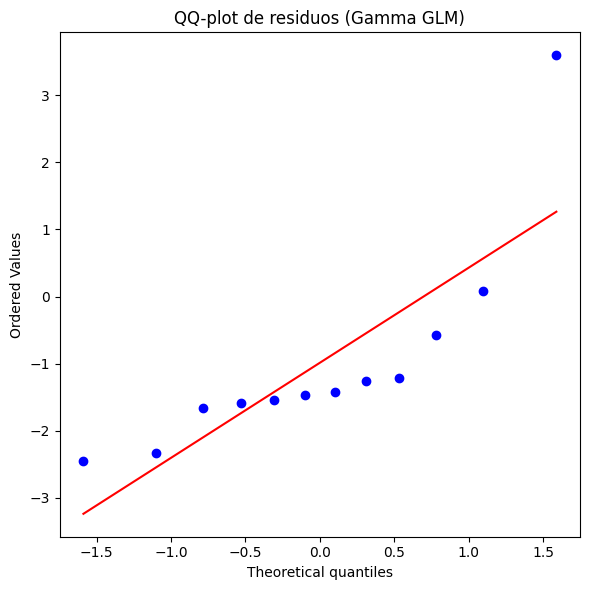

In [9]:
plt.figure(figsize=(6, 6))
st.probplot(resid_dev, dist="norm", plot=plt)
plt.title("QQ-plot de residuos (Gamma GLM)")
plt.tight_layout()
plt.show()

### 8.2 Residuos vs Valores Ajustados

Verificamos homocedasticidad y patrones en los residuos.

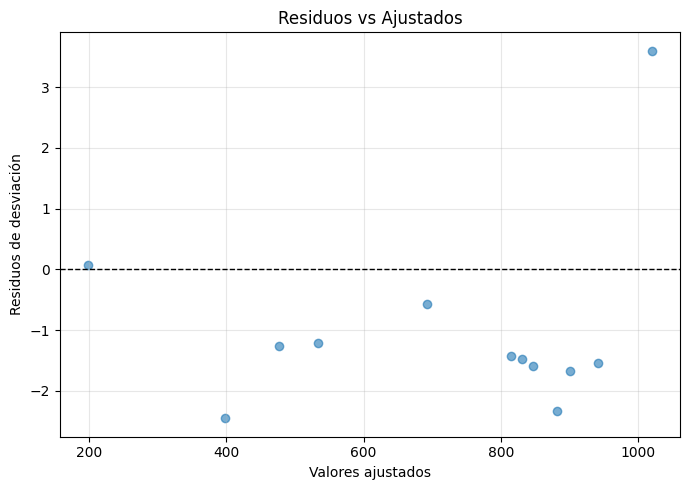

In [10]:
plt.figure(figsize=(7, 5))
plt.scatter(fitted, resid_dev, alpha=0.6)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos de desviación")
plt.title("Residuos vs Ajustados")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8.3 Test de Breusch-Pagan

Prueba formal de heterocedasticidad.

In [11]:
bp = het_breuschpagan(resid_dev, sm.add_constant(fitted))

print("============================")
print("TEST DE BREUSCH-PAGAN")
print("============================")
print(f"Estadístico LM: {bp[0]:.4f}")
print(f"Valor p: {bp[1]:.4f}")
print(f"Estadístico F: {bp[2]:.4f}")
print(f"Valor p (F): {bp[3]:.4f}")

if bp[1] > 0.05:
    print("\n✔ No hay evidencia de heterocedasticidad fuerte (p > 0.05).")
else:
    print("\n⚠ Posible heterocedasticidad (p ≤ 0.05).")

TEST DE BREUSCH-PAGAN
Estadístico LM: 2.2991
Valor p: 0.1294
Estadístico F: 2.3700
Valor p (F): 0.1547

✔ No hay evidencia de heterocedasticidad fuerte (p > 0.05).


### 8.4 Observaciones Influyentes (Distancia de Cook)

Identificamos puntos que tienen influencia desproporcionada en el modelo.

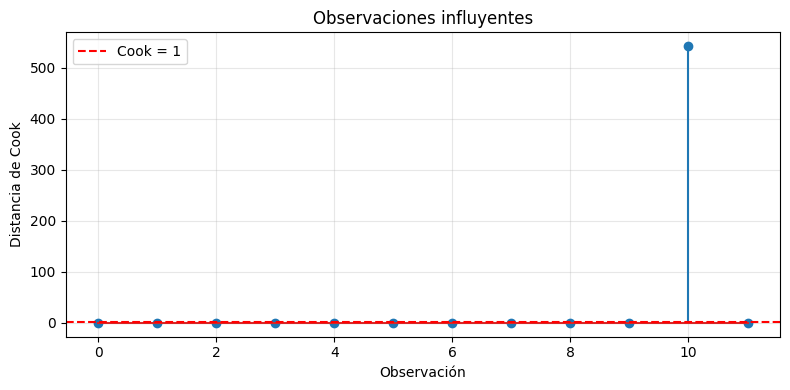

OBSERVACIONES INFLUYENTES
Observaciones con Cook > 1: [10]

Detalles de observaciones influyentes:
   Unidad  densidad_ponderada  apertura
10     11              9938.0  0.925807

Máxima distancia de Cook: 542.4360
Observación con mayor Cook: 10


In [12]:
influence = model.get_influence()
cooks = influence.cooks_distance[0]

plt.figure(figsize=(8, 4))
plt.stem(cooks)
plt.axhline(1, color='red', linestyle='--', label='Cook = 1')
plt.xlabel("Observación")
plt.ylabel("Distancia de Cook")
plt.title("Observaciones influyentes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

influential_obs = np.where(cooks > 1)[0]
print("============================")
print("OBSERVACIONES INFLUYENTES")
print("============================")
if len(influential_obs) > 0:
    print(f"Observaciones con Cook > 1: {influential_obs}")
    print("\nDetalles de observaciones influyentes:")
    print(df.iloc[influential_obs][["Unidad", "densidad_ponderada", "apertura"]])
else:
    print("✔ No hay observaciones con Cook > 1")

print(f"\nMáxima distancia de Cook: {cooks.max():.4f}")
print(f"Observación con mayor Cook: {cooks.argmax()}")

## 9. Conclusiones

Resumen del análisis realizado.

In [13]:
print("=" * 60)
print("RESUMEN DEL ANÁLISIS GAMMA GLM")
print("=" * 60)
print(f"\n📊 Modelo: densidad_ponderada ~ apertura_s")
print(f"📊 Familia: Gamma con enlace log")
print(f"📊 Observaciones: {n}")
print(f"\n📈 Resultados:")
print(f"   - Coeficiente apertura_s: {beta:.4f} (p = {p_value:.4f})")
print(f"   - Exp(β): {exp_beta:.4f}")
print(f"   - R² McFadden: {r2_mcfadden:.4f}")
print(f"   - R² Nagelkerke: {r2_nagelkerke:.4f}")
print(f"\n✅ Modelo con apertura_s estimado correctamente.")
print("=" * 60)

RESUMEN DEL ANÁLISIS GAMMA GLM

📊 Modelo: densidad_ponderada ~ apertura_s
📊 Familia: Gamma con enlace log
📊 Observaciones: 12

📈 Resultados:
   - Coeficiente apertura_s: 0.4571 (p = 0.5841)
   - Exp(β): 1.5795
   - R² McFadden: 0.0108
   - R² Nagelkerke: 0.1510

✅ Modelo con apertura_s estimado correctamente.


In [14]:
# Extraer resultados para la tabla
coeficientes = model.params
errores = model.bse
z_values = model.tvalues
p_values = model.pvalues
aic = model.aic

# Crear tabla resumen
tabla_resumen = pd.DataFrame({
    'Variable respuesta': ['Densidad ponderada de inflorescencias'] * len(coeficientes), # Nombre más descriptivo
    'Modelo (familia)': ['GLM Gamma (log)'] * len(coeficientes),
    'Variables explicativas': coeficientes.index,
    'Coeficiente': coeficientes.values,
    'Error estándar': errores.values,
    'z': z_values.values,
    'p': p_values.values,
    'AIC': [aic] * len(coeficientes)
})

# Formatear tabla
# Mapear nombres de variables
nombres_vars = {'Intercept': 'Intercepto', 'apertura_s': 'Apertura_s'}
tabla_resumen['Variables explicativas'] = tabla_resumen['Variables explicativas'].map(nombres_vars).fillna(tabla_resumen['Variables explicativas'])

# Reordenar columnas
cols = ['Variable respuesta', 'Modelo (familia)', 'Variables explicativas', 'Coeficiente', 'Error estándar', 'z', 'p', 'AIC']
tabla_resumen = tabla_resumen[cols]

print("\nTabla de Resultados Importantes:")
print(tabla_resumen)

# Opcional: Mostrar bonito en notebook
display(tabla_resumen)


Tabla de Resultados Importantes:
                      Variable respuesta Modelo (familia)  \
0  Densidad ponderada de inflorescencias  GLM Gamma (log)   
1  Densidad ponderada de inflorescencias  GLM Gamma (log)   

  Variables explicativas  Coeficiente  Error estándar         z             p  \
0             Intercepto     6.482237        0.835005  7.763107  8.287350e-15   
1             Apertura_s     0.457095        0.835005  0.547415  5.840935e-01   

          AIC  
0  184.194006  
1  184.194006  


,Variable respuesta,Modelo (familia),Variables explicativas,Coeficiente,Error estándar,z,p,AIC
0,Densidad ponderada de inflorescencias,GLM Gamma (log),Intercepto,6.482237,0.835005,7.763107,8.287350e-15,184.194006
1,Densidad ponderada de inflorescencias,GLM Gamma (log),Apertura_s,0.457095,0.835005,0.547415,5.840935e-01,184.194006
